## Mengimport library yang dibutuhkan

In [505]:
"""
Nama Kelompok:
1. Akmal Muzakki Bakir  (1305210087)
2. Namira Salsabilla    (1305210091)
3. Haura Adzkia Delfina (1305213006)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats
import torch

from pmdarima.arima import auto_arima
from matplotlib import pyplot as plt
from copy import deepcopy
from tqdm import tqdm

from scipy.stats import boxcox
from scipy.stats import shapiro, kstest
from scipy import stats

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from torch import nn
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

## Dataset

In [506]:
df = pd.read_excel('2. Data Temperatur Maksimum.xlsx')
df.head()

,Tanggal,Temperatur Maksimum
0,2005-01-01,27.8
1,2005-01-02,29.1
2,2005-01-03,28.6
3,2005-01-04,28.4
4,2005-01-05,27.8


In [507]:
df.describe()

,Temperatur Maksimum
count,3161.000000
mean,28.917811
std,1.584289
min,19.600000
25%,28.000000
50%,29.000000
75%,30.000000
max,36.000000


In [508]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3165 entries, 0 to 3164
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Tanggal              3165 non-null   datetime64[ns]
 1   Temperatur Maksimum  3161 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 49.6 KB


In [509]:
"""
Studi Kasus: Data temperatur maksimum

Data yang akan diolah merupakan data dengan 3.165 baris dengan 2 buah atribut, yaitu:
1. Tanggal (YYYY-MM-DD): Berisi informasi mengenai data tahun, bulan, dan tanggal.
2. Temperatur Maksimum(°C): Berisi informasi mengenai data temperatur maksimum dengan derajat ukur berupa celcius pada tanggal tersebut.
"""

'\nStudi Kasus: Data temperatur maksimum\n\nData yang akan diolah merupakan data dengan 3.165 baris dengan 2 buah atribut, yaitu:\n1. Tanggal (YYYY-MM-DD): Berisi informasi mengenai data tahun, bulan, dan tanggal.\n2. Temperatur Maksimum(°C): Berisi informasi mengenai data temperatur maksimum dengan derajat ukur berupa celcius pada tanggal tersebut.\n'

In [510]:
"""
Mengecek nilai yang hilang
"""

df.isnull().sum()

Tanggal                0
Temperatur Maksimum    4
dtype: int64

In [511]:
"""
Menggunakan metode imputasi untuk mengisi nilai yang hilang dengan strategi mean
"""

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(df[['Temperatur Maksimum']])
df[['Temperatur Maksimum']] = imputer.transform(df[['Temperatur Maksimum']])
df.isnull().sum()

Tanggal                0
Temperatur Maksimum    0
dtype: int64

In [512]:
"""
Plotting data temperatur maksimum
"""

fig = px.line(df, x='Tanggal', y='Temperatur Maksimum', title='Temperatur Maksimum')
fig.show()

## Box-Cox

In [513]:
"""
Periksa apakah ada data yang bernilai negatif, karena Transformasi Box-Cox hanya dapat digunakan untuk data yang bernilai positif
"""

df[df['Temperatur Maksimum'] < 0]

,Tanggal,Temperatur Maksimum


In [514]:
"""
Periksa apakah data berdistribusi normal atau tidak menggunakan uji Shapiro-Wilk dan uji Kolmogorov-Smirnov
"""

'\nPeriksa apakah data berdistribusi normal atau tidak menggunakan uji Shapiro-Wilk dan uji Kolmogorov-Smirnov\n'

### Uji Shapiro-Wilk dan Kolmogorov-Smirnov sebelum transformasi

In [515]:
"""
Uji Shapiro-Wilk adalah uji statistik yang digunakan untuk menguji apakah suatu sampel data berasal dari distribusi normal. 
Rumusnya cukup kompleks dan melibatkan beberapa parameter statistik, tetapi pada dasarnya dapat dijelaskan sebagai berikut:

W = (∑ni=1aix(i))^2 / ∑ni=1(xi-x¯)^2

dimana:
- W adalah statistik uji
- n adalah jumlah sampel
- x(i) adalah nilai observasi ke-i
- x¯ adalah rata-rata sampel
- a(i) adalah koefisien yang bergantung pada nilai observasi ke-i dan n, yang dihitung berdasarkan polinom kecil yang telah ditentukan sebelumnya

Dalam uji Shapiro-Wilk, hipotesis nol (H0) adalah bahwa data berasal dari distribusi normal.
Hipotesis alternatif (H1) adalah bahwa data tidak berasal dari distribusi normal.
"""


"""
Uji Kolmogorov-Smirnov (KS) adalah uji statistik yang digunakan untuk menguji apakah suatu sampel data berasal dari distribusi tertentu (dalam hal ini, distribusi normal). 
Uji ini membandingkan fungsi distribusi kumulatif empiris (ECDF) dari sampel data dengan fungsi distribusi kumulatif (CDF) dari distribusi yang diuji.

Rumus dari uji Kolmogorov-Smirnov untuk distribusi normal kumulatif adalah sebagai berikut:

D = max|F(x)-Sn(x)|

dimana:
- D adalah statistik uji
- F(x) adalah ECDF dari distribusi normal
- Sn(x) adalah CDF dari sampel data
- max adalah fungsi yang mengembalikan nilai maksimum dari selisih antara F(x) dan Sn(x)

Dalam uji ini, kita membandingkan nilai D dengan nilai kritis dari distribusi Kolmogorov-Smirnov untuk menentukan 
apakah kita dapat menolak hipotesis nol (H0) bahwa data berasal dari distribusi normal.
"""

def norm_test(data):
    shapiro_stat, shapiro_p_val = shapiro(data)
    print(f'Shapiro Statistic: {shapiro_stat}')
    print(f'Shapiro P-Value: {shapiro_p_val}')
    if shapiro_p_val < 0.05:
        print('Data tidak berdistribusi normal berdasarkan uji Shapiro-Wilk')
    else:
        print('Data berdistribusi normal berdasarkan uji Shapiro-Wilk')
        
    print('\n')
    
    ks_stat, ks_p_val = kstest(
        rvs=df['Temperatur Maksimum'], 
        cdf=stats.norm.cdf, 
        args=(df['Temperatur Maksimum'].mean(), df['Temperatur Maksimum'].std())
    )
    print(f'KS Statistic: {ks_stat}')
    print(f'KS P-Value: {ks_p_val}')
    if ks_p_val < 0.05:
        print('Data tidak berdistribusi normal berdasarkan uji Kolmogorov-Smirnov')
    else:
        print('Data berdistribusi normal berdasarkan uji Kolmogorov-Smirnov')

In [516]:
norm_test(df['Temperatur Maksimum'])

Shapiro Statistic: 0.9875832200050354
Shapiro P-Value: 4.91927671947295e-16
Data tidak berdistribusi normal berdasarkan uji Shapiro-Wilk


KS Statistic: 0.05687692246436349
KS P-Value: 2.4295365735359098e-09
Data tidak berdistribusi normal berdasarkan uji Kolmogorov-Smirnov


In [517]:
"""
Karena data tidak berdistribusi normal berdasarkan kedua uji tersebut, 
maka dilakukan transformasi Box-Cox untuk membuat data mendekati distribusi normal
"""

'\nKarena data tidak berdistribusi normal berdasarkan kedua uji tersebut, \nmaka dilakukan transformasi Box-Cox untuk membuat data mendekati distribusi normal\n'

### Transformasi Box-Cox

In [518]:
"""
Transformasi Box-Cox adalah metode statistik yang digunakan untuk mengubah data yang tidak terdistribusi normal menjadi distribusi normal. 
Transformasi ini berguna dalam situasi di mana asumsi-asumsi analisis statistik atau model deret waktu memerlukan data yang terdistribusi normal.

Rumus umum transformasi Box-Cox adalah sebagai berikut:
y = (x^lambda - 1) / lambda ; lambda != 0
y = log(x) ; lambda = 0

Disini, y adalah data yang sudah ditransformasi, x adalah data asli, dan lambda adalah parameter transformasi yang akan dicari.

Setelah data ditransformasi, data diharapkan menjadi lebih mendekati distribusi normal.

Dalam kasus ini, nilai lambda pada parameter Box-Cox di set menjadi None, sehingga nilai lambda akan dicari secara otomatis.
Nilai lambda yang dicari adalah nilai lambda yang menghasilkan nilai likelihood yang paling tinggi.
"""

def apply_boxcox(data):
    data_boxcox, max_lambda = boxcox(data, lmbda=None)
    return data_boxcox, max_lambda

df['Temperatur Maksimum Boxcox'], max_lambda = apply_boxcox(df['Temperatur Maksimum'])
df.head()

,Tanggal,Temperatur Maksimum,Temperatur Maksimum Boxcox
0,2005-01-01,27.8,1002.685278
1,2005-01-02,29.1,1115.563036
2,2005-01-03,28.6,1071.334267
3,2005-01-04,28.4,1053.928413
4,2005-01-05,27.8,1002.685278


In [519]:
"""
Hasil print dibawah merupakan nilai lambda maksimum yang menghasilkan nilai likelihood yang paling tinggi
"""

print(f'Lambda: {max_lambda}')

Lambda: 2.3332452205390966


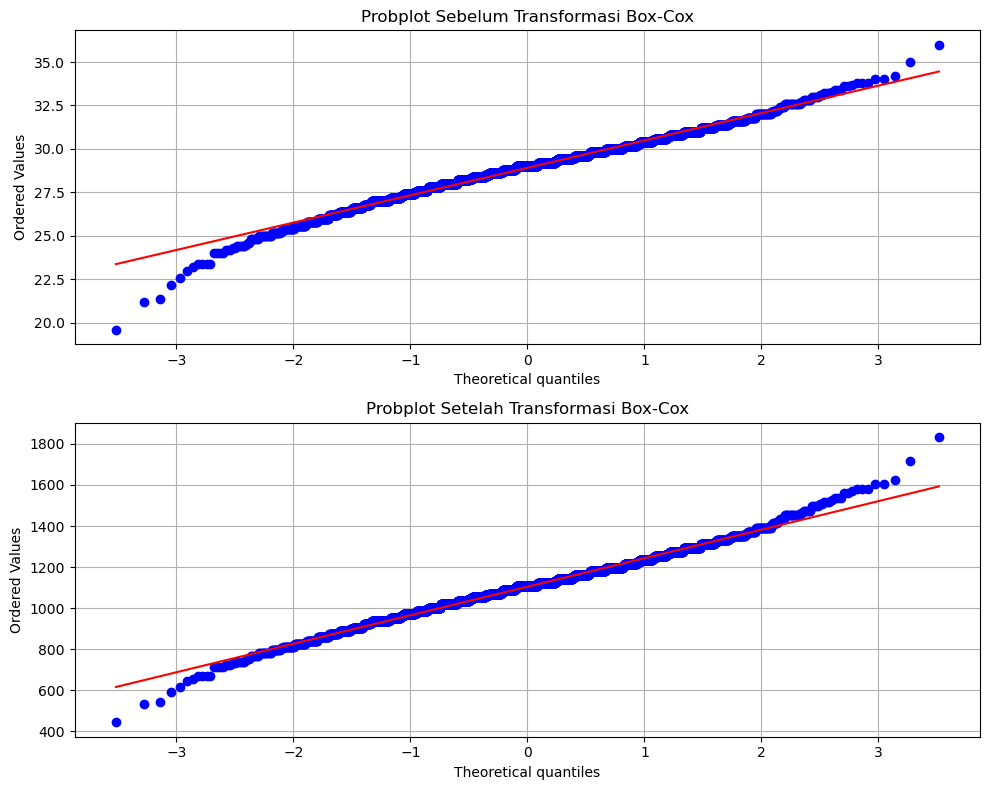

In [520]:
"""
Probplot adalah sebuah grafik yang membandingkan dua distribusi probabilitas. 
Probplot pertama menggambarkan sejauh mana data cocok dengan distribusi normal sebelum transformasi Box-Cox, 
sedangkan probplot kedua menggambarkan sejauh mana data cocok dengan distribusi normal setelah transformasi Box-Cox. 

Probplot membantu dalam memvisualisasikan efek transformasi terhadap distribusi data.
"""

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

probplot_before = stats.probplot(
    df['Temperatur Maksimum'], 
    dist=stats.norm, 
    plot=ax1
)

ax1.set_title('Probplot Sebelum Transformasi Box-Cox')
ax1.grid(True)

probplot_after = stats.probplot(
    df['Temperatur Maksimum Boxcox'], 
    dist=stats.norm, 
    plot=ax2
)

ax2.set_title('Probplot Setelah Transformasi Box-Cox')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [521]:
"""
Penjelasan grafik diatas:

- Sumbu X (Theoretical Quantiles): 
  Ini adalah nilai-nilai yang diharapkan dari distribusi probabilitas tertentu. Jika kita menggunakan distribusi normal sebagai referensi, 
  sumbu x akan menunjukkan kuantil-kuantil yang diharapkan dari distribusi normal.
- Sumbu Y (Ordered Values): 
  Ini adalah nilai-nilai dari data yang diuji yang telah diurutkan dari yang terkecil hingga yang terbesar. 
  Sumbu y ini merepresentasikan data aktual yang akan dibandingkan dengan kuantil teoritis pada sumbu x.
"""

'\nPenjelasan grafik diatas:\n\n- Sumbu X (Theoretical Quantiles): \n  Ini adalah nilai-nilai yang diharapkan dari distribusi probabilitas tertentu. Jika kita menggunakan distribusi normal sebagai referensi, \n  sumbu x akan menunjukkan kuantil-kuantil yang diharapkan dari distribusi normal.\n- Sumbu Y (Ordered Values): \n  Ini adalah nilai-nilai dari data yang diuji yang telah diurutkan dari yang terkecil hingga yang terbesar. \n  Sumbu y ini merepresentasikan data aktual yang akan dibandingkan dengan kuantil teoritis pada sumbu x.\n'

### Uji Shapiro-Wilk dan Kolmogorov-Smirnov setelah transformasi

In [522]:
norm_test(df['Temperatur Maksimum Boxcox'])

Shapiro Statistic: 0.9919828176498413
Shapiro P-Value: 2.638514190120289e-12
Data tidak berdistribusi normal berdasarkan uji Shapiro-Wilk


KS Statistic: 0.05687692246436349
KS P-Value: 2.4295365735359098e-09
Data tidak berdistribusi normal berdasarkan uji Kolmogorov-Smirnov


In [523]:
"""
Walaupun data masih belum berdistribusi normal, tetapi sudah lebih mendekati distribusi normal daripada sebelumnya.
Karena nilai p-value dari uji Shapiro-Wilk dan uji Kolmogorov-Smirnov sudah lebih mendekati ke 0.05 daripada sebelumnya.
Dan nilai p-value dari uji Shapiro-Wilk dan uji Kolmogorov-Smirnov sudah lebih besar daripada sebelumnya.
"""

'\nWalaupun data masih belum berdistribusi normal, tetapi sudah lebih mendekati distribusi normal daripada sebelumnya.\nKarena nilai p-value dari uji Shapiro-Wilk dan uji Kolmogorov-Smirnov sudah lebih mendekati ke 0.05 daripada sebelumnya.\nDan nilai p-value dari uji Shapiro-Wilk dan uji Kolmogorov-Smirnov sudah lebih besar daripada sebelumnya.\n'

In [524]:
"""
Plot data temperatur maksimum yang sudah ditransformasi
"""

fig = px.line(df, x='Tanggal', y='Temperatur Maksimum Boxcox', title='Temperatur Maksimum Boxcox')
fig.show()

In [525]:
"""
Rolling Mean:
- Ini adalah rata-rata bergerak (moving average) dari deret waktu temperatur maksimum setelah di-transformasi dengan metode Box-Cox.
- Rata-rata bergerak digunakan untuk menghaluskan tren atau fluktuasi dalam data dan membuatnya lebih mudah untuk melihat pola jangka panjang.

Rolling Standard Deviation:
- Ini adalah standar deviasi bergerak dari deret waktu temperatur maksimum setelah di-transformasi dengan metode Box-Cox.
- Standar deviasi bergerak digunakan untuk melihat variasi atau fluktuasi dalam data sepanjang waktu.
"""

rolling_mean = df['Temperatur Maksimum Boxcox'].rolling(window=12).mean()
rolling_std = df['Temperatur Maksimum Boxcox'].rolling(window=12).std()

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df['Tanggal'], 
    y=df['Temperatur Maksimum Boxcox'],
    mode='lines',
    name='Original'
))

fig.add_trace(go.Scatter(
    x=df['Tanggal'], 
    y=rolling_mean,
    mode='lines',
    name='Rolling Mean'
))

fig.add_trace(go.Scatter(
    x=df['Tanggal'], 
    y=rolling_std,
    mode='lines',
    name='Rolling Std'
))

fig.update_layout(
    title='Rolling Mean & Standard Deviation',
    xaxis_title='Tanggal',
    yaxis_title='Temperatur Maksimum Boxcox'
)

fig.show()

## Uji ADF

In [526]:
"""
Uji ADF (Augmented Dickey-Fuller) adalah salah satu uji statistik yang digunakan dalam analisis deret waktu untuk menentukan apakah suatu deret waktu stasioner atau tidak. 
Stasioneritas adalah sifat yang penting dalam analisis deret waktu karena banyak metode statistik dan model deret waktu memerlukan asumsi stasioneritas.
"""

def adf_test(data):
    print("Temperature Max Boxcox")
    
    adf = adfuller(data, autolag='AIC')
    print('ADF Statistic: ', adf[0])
    print('p-value: ', adf[1])
    if adf[1] < 0.05:
        print('Data stasioner berdasarkan p-value')
    else:
        print('Data tidak stasioner berdasarkan p-value')
        
    print()
        
    print('Critical Values:')
    for key, value in adf[4].items():
        print('\t%s: %.3f' % (key, value))
        if adf[0] < value:
            print('Data stasioner berdasarkan critical value')
        else:
            print('Data tidak stasioner berdasarkan critical value')

adf_test(df["Temperatur Maksimum Boxcox"])

Temperature Max Boxcox
ADF Statistic:  -6.8903578926815445
p-value:  1.360635143391033e-09
Data stasioner berdasarkan p-value

Critical Values:
	1%: -3.432
Data stasioner berdasarkan critical value
	5%: -2.862
Data stasioner berdasarkan critical value
	10%: -2.567
Data stasioner berdasarkan critical value


## Plot ACF dan PACF

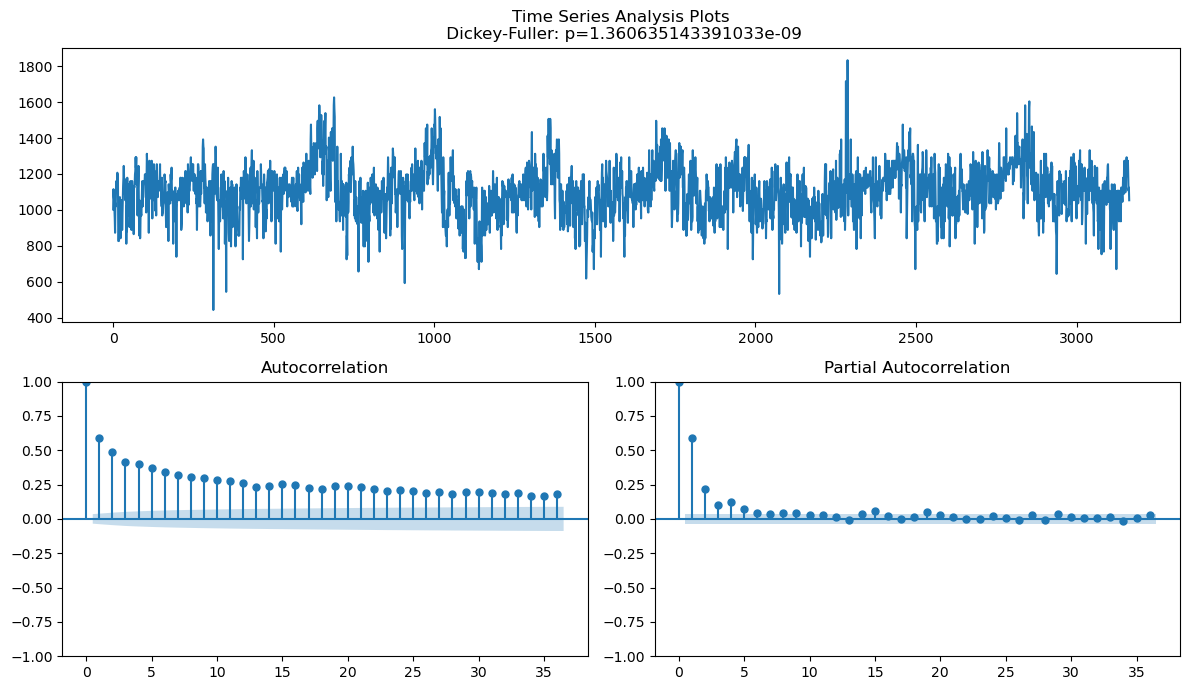

In [527]:
"""
Autocorrelation Function (ACF) dan Partial Autocorrelation Function (PACF) merupakan dua hal penting dalam analisis deret waktu untuk memahami pola korelasi dalam data. 
ACF dan PACF dapat membantu dalam mengidentifikasi model statistik yang sesuai untuk menganalisis dan memprediksi data deret waktu.

ACF :
- plot dari korelasi antara data pada suatu lag dengan data pada lag yang sebelumnya
- Nilai-nilai ACF pada lag yang lebih besar dapat memberikan informasi tentang korelasi dalam data pada interval waktu tertentu.

PACF :
- plot dari korelasi antara data pada suatu lag dengan data pada lag sebelumnya setelah menghapus pengaruh lag-lag yang berada diantara keduanya
- PACF membantu dalam mengidentifikasi model AR (Autoregressive) dalam analisis deret waktu.
"""

"""
+ Model AR
- Pilih model AR jika ACF menunjukkan pola eksponensial yang mendekati 0
- Orde AR(p) dapat diidentifikasi dari PACF yang mengalami cutoff setelah lag tertentu

+ Model MA
- Pilih model MA jika ACF menunjukkan pola yang mengalami cutoff setelah lag tertentu
- Orde MA(q) dapat diidentifikasi dari ACF yang mengalami cutoff setelah lag tertentu

+ Model ARMA
- Pilih model ARMA jika ACF dan PACF menunjukkan pola yang mendekati 0 dan mengalami cutoff setelah lag tertentu
- Menentukan orde AR dan MA dengan melihat ACF dan PACF

+ Model ARIMA
- Pilih model ARIMA(p, d, q) jika data tidak stasioner (d > 0) dan ACF serta PACF menunjukkan pola yang mendekati 0 dan mengalami cut-off setelah lag tertentu.
- Orde differencing (d) bisa diidentifikasi berdasarkan berapa kali differencing yang diperlukan untuk menjadikan data stasioner.
- Orde AR (p) dan orde MA (q) dapat diidentifikasi dari plot ACF dan PACF dari data yang telah di-differencing.
"""

fig = plt.figure(figsize=(12, 7))

ts_ax = plt.subplot2grid(
    shape=(2, 2), 
    loc=(0, 0), 
    colspan=2
)

acf_ax = plt.subplot2grid(
    shape=(2, 2), 
    loc=(1, 0)
)

pacf_ax = plt.subplot2grid(
    shape=(2, 2), 
    loc=(1, 1)
)

p_value = adfuller(
    df['Temperatur Maksimum Boxcox'], 
    autolag='AIC'
)[1]

df['Temperatur Maksimum Boxcox'].plot(ax=ts_ax)
plot_acf(df['Temperatur Maksimum Boxcox'], lags=None, ax=acf_ax)
plot_pacf(df['Temperatur Maksimum Boxcox'], lags=None, ax=pacf_ax)

ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={}'.format(p_value))
plt.tight_layout()

In [528]:
"""
ACF:
- Dari visualisasi diatas didapatkan bahwa ACF mengalami penurunan secara eksponensial dimulai dari lag 3 atau setelah lag ke 2.

PACF:
- Dari visualisasi diatas didapatkan bahwa PACF mengalami cutoff setelah lag ke 5.

Dapat disimpulkan bahwa menggunakan ACF dan PACF bersamaan dapat menentukan orde AR, MA (Moving Average), 
dan I (Integrated) yang tepat untuk model ARIMA yang akan digunakan dalam pemodelan deret waktu. 
Dan dari hasil visualisasi maka model yang digunakan adalah ARMA(3, 5) atau ARIMA(3, 0, 5)
"""

'\nACF:\n- Dari visualisasi diatas didapatkan bahwa ACF mengalami penurunan secara eksponensial dimulai dari lag 3 atau setelah lag ke 2.\n\nPACF:\n- Dari visualisasi diatas didapatkan bahwa PACF mengalami cutoff setelah lag ke 5.\n\nDapat disimpulkan bahwa menggunakan ACF dan PACF bersamaan dapat menentukan orde AR, MA (Moving Average), \ndan I (Integrated) yang tepat untuk model ARIMA yang akan digunakan dalam pemodelan deret waktu. \nDan dari hasil visualisasi maka model yang digunakan adalah ARMA(3, 5) atau ARIMA(3, 0, 5)\n'

In [529]:
test_df = pd.DataFrame([
    acf(df['Temperatur Maksimum Boxcox']), 
    pacf(df['Temperatur Maksimum Boxcox'])
]).T
test_df.columns = ['ACF', 'PACF']
test_df.index += 1
test_df.head()

,ACF,PACF
1,1.000000,1.000000
2,0.589155,0.589341
3,0.487506,0.215253
4,0.417139,0.104542
5,0.400217,0.120180


## Identifikasi model ARIMA

In [530]:
"""
Pencarian parameter ARIMA terbaik menggunakan metode Auto ARIMA dengan kriteria AIC
"""

auto_arima(
    df['Temperatur Maksimum Boxcox'], 
    seasonal=True, 
    stationary=True, 
    trace=True, 
    error_action='ignore', 
    suppress_warnings=True, 
    information_criterion='aic'
).summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=38668.229, Time=2.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=40237.300, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=38890.016, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=39407.051, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=53388.800, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=38715.200, Time=0.40 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=38726.518, Time=2.47 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=38656.774, Time=2.59 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=38708.326, Time=0.72 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=38658.004, Time=2.37 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=38644.946, Time=2.30 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=38647.511, Time=1.60 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=38633.760, Time=3.54 sec
 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=38636.822, Time=4.05 sec
 ARIMA(4,0,4)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3165
Model:               SARIMAX(3, 0, 5)   Log Likelihood              -19304.225
Date:                Tue, 26 Dec 2023   AIC                          38628.450
Time:                        20:42:28   BIC                          38689.049
Sample:                             0   HQIC                         38650.188
                               - 3165                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    205.0317    113.282      1.810      0.070     -16.997     427.060
ar.L1         -0.6611      0.952     -0.695      0.487      -2.527       1.205
ar.L2          0.6920      0.388      1.785      0.074      -0.068       1.452
ar.L3          0.7836      0.889      0.881      0.378      -0.959       2.526
ma.L1          1.0678      0.953      1.120      0.263      -0.801       2.936
ma.L2         -0.1269      0.516     -0.246      0.806      -1.139       0.885
ma.L3         -0.6714      0.582     -1.154      0.248      -1.812       0.469
ma.L4         -0.2033      0.164     -1.237      0.216      -0.526       0.119
ma.L5         -0.0642      0.087     -0.735      0.462      -0.235       0.107
sigma2      1.164e+04    211.885     54.934      0.000    1.12e+04    1.21e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               643.44
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.28
Prob(H) (two-sided):                  0.32   Kurtosis:                         5.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ARIMA (3, 0, 5)

In [531]:
"""
Inisiasi model ARIMA dengan parameter p=3, d=0, dan q=5 dengan metode maximum likelihood estimation.
Metode ini memaksimalkan fungsi likelihood untuk mendapatkan nilai parameter yang paling mungkin terjadi.
"""

model = ARIMA(df['Temperatur Maksimum Boxcox'], order=(3, 0, 5))
model_fit = model.fit(method='innovations_mle')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                    
======================================================================================
Dep. Variable:     Temperatur Maksimum Boxcox   No. Observations:                 3165
Model:                         ARIMA(3, 0, 5)   Log Likelihood              -19298.073
Date:                        Tue, 26 Dec 2023   AIC                          38616.146
Time:                                20:42:48   BIC                          38676.745
Sample:                                     0   HQIC                         38637.884
                                       - 3165                                         
Covariance Type:                          opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1104.2944     11.618     95.053      0.000    1081.524    1127.065
ar.L1         -0.5748      0.009    -63.339      0.000      -0.593      -0.557
ar.L2          0.4722      0.013     37.150      0.000       0.447       0.497
ar.L3          0.9461      0.009    105.375      0.000       0.929       0.964
ma.L1          0.9842      0.022     45.154      0.000       0.941       1.027
ma.L2          0.0565      0.030      1.913      0.056      -0.001       0.114
ma.L3         -0.7848      0.029    -26.844      0.000      -0.842      -0.727
ma.L4         -0.2290      0.028     -8.166      0.000      -0.284      -0.174
ma.L5         -0.0879      0.019     -4.629      0.000      -0.125      -0.051
sigma2      1.156e+04    249.308     46.372      0.000    1.11e+04     1.2e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               642.63
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.27
Prob(H) (two-sided):                  0.36   Kurtosis:                         5.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [532]:
"""
Output tersebut adalah hasil dari pemodelan menggunakan metode SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous factors) 
pada data deret waktu temperatur maksimum yang telah di-transformasi menggunakan Box-Cox. Berikut adalah penjelasan dari output tersebut:

1. Dep. Variable: Temperatur Maksimum Boxcox
   - Variabel dependen yang digunakan dalam analisis ini adalah "Temperatur Maksimum Boxcox," yang merupakan data deret waktu temperatur yang telah di-transformasi menggunakan metode Box-Cox.

2. Model: ARIMA(3, 0, 5)
   - Model ARIMA yang digunakan memiliki parameter (p, d, q) sebagai (3, 0, 5), yang berarti terdapat komponen autoregressive (AR) sebanyak 3, komponen integrated (I) sebanyak 0 (menunjukkan bahwa data sudah stasioner setelah diferensiasi), dan komponen moving average (MA) sebanyak 5.

3. Log Likelihood: -19298.073
   - Log likelihood adalah nilai logaritma likelihood dari model. Semakin tinggi nilai ini, semakin baik modelnya.

4. AIC (Akaike Information Criterion): 38616.146
   - AIC adalah suatu metode untuk pembandingan model. Semakin rendah nilai AIC, semakin baik modelnya.

5. BIC (Bayesian Information Criterion): 38676.745
   - BIC juga digunakan untuk pembandingan model. Seperti AIC, semakin rendah nilai BIC, semakin baik modelnya.

6. Koefisien (coef) dan Standar Error (std err) ARIMA:
   - Koefisien mengindikasikan seberapa besar dampak setiap variabel pada model. Standar error mengukur ketidakpastian estimasi koefisien. 
     Koefisien dengan nilai signifikan (p-value kecil) biasanya lebih penting.

7. Sigma2 (Varians Residual): 1.156e+04
   - Sigma2 adalah estimasi varians dari sisa model (residuals).

8. Ljung-Box (Q) Statistic: 0.00
   - Ljung-Box adalah uji statistik untuk menguji kemandirian (tidak ada pola) dalam sisa model. Nilai rendah menunjukkan bahwa sisa tidak memiliki pola yang signifikan.

9. Jarque-Bera (JB) Statistic: 642.63
   - JB Statistic adalah uji statistik untuk menguji normalitas dari residual. P-value yang rendah menunjukkan bahwa residual tidak terdistribusi normal.

10. Heteroskedasticity (H) Statistic: 1.06
    - H Statistic mengukur kehadiran heteroskedastisitas dalam sisa model. Nilai mendekati 1 menunjukkan bahwa tidak ada heteroskedastisitas yang signifikan.

11. Skewness dan Kurtosis:
    - Skewness mengukur kemiringan distribusi residual. Nilai mendekati 0 menunjukkan distribusi simetris. Kurtosis mengukur keruncingan distribusi residual. 
      Nilai lebih besar dari 3 menunjukkan distribusi lebih meruncing.

Output ini memberikan informasi penting tentang kualitas model, signifikansi variabel, dan asumsi-asumsi yang telah diuji. 
Model ini tampaknya memiliki log likelihood yang tinggi dan nilai AIC serta BIC yang relatif rendah, namun, interpretasi yang lebih mendalam memerlukan pemahaman yang lebih mendalam tentang data dan konteksnya.
"""

'\nOutput tersebut adalah hasil dari pemodelan menggunakan metode SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous factors) \npada data deret waktu temperatur maksimum yang telah di-transformasi menggunakan Box-Cox. Berikut adalah penjelasan dari output tersebut:\n\n1. Dep. Variable: Temperatur Maksimum Boxcox\n   - Variabel dependen yang digunakan dalam analisis ini adalah "Temperatur Maksimum Boxcox," yang merupakan data deret waktu temperatur yang telah di-transformasi menggunakan metode Box-Cox.\n\n2. Model: ARIMA(3, 0, 5)\n   - Model ARIMA yang digunakan memiliki parameter (p, d, q) sebagai (3, 0, 5), yang berarti terdapat komponen autoregressive (AR) sebanyak 3, komponen integrated (I) sebanyak 0 (menunjukkan bahwa data sudah stasioner setelah diferensiasi), dan komponen moving average (MA) sebanyak 5.\n\n3. Log Likelihood: -19298.073\n   - Log likelihood adalah nilai logaritma likelihood dari model. Semakin tinggi nilai ini, semakin baik modelnya.\n\n4. 

In [533]:
"""
Plot data perbandingan antara data temperatur maksimum setelah di-transformasi dengan metode Box-Cox dan model ARMA(3, 5).
"""

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df['Tanggal'], 
    y=df['Temperatur Maksimum Boxcox'],
    mode='lines',
    name='Orginal Data',
))

fig.add_trace(go.Scatter(
    x=df['Tanggal'], 
    y=model_fit.fittedvalues,
    mode='lines',
    name='ARMA(3, 5)'
))

fig.update_layout(
    title='Time Series Data Temperature',
    xaxis_title='Tanggal',
    yaxis_title='Temperature (%)',
    template='plotly_white'
)

fig.show()

## Metode Ljung-Box

In [534]:
residuals = pd.DataFrame(model_fit.resid, columns=['Residuals'])
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df['Tanggal'], 
    y=residuals['Residuals'],
    mode='lines',
    name='Residuals'
))

fig.update_layout(   
    title='Residuals',
    xaxis_title='Tanggal',
    yaxis_title='Residuals',
    template='plotly_white'
)

In [535]:
"""
Metode Ljung-Box, juga dikenal sebagai uji Ljung-Box, adalah suatu uji statistik yang digunakan dalam analisis deret waktu untuk menguji 
apakah ada korelasi signifikan dalam sampel lag dalam deret waktu tersebut. 
Uji ini membantu menentukan apakah residual dari suatu model deret waktu bersifat acak atau mengandung pola-pola korelasi yang tidak terdeteksi.

Tujuan utama dari Metode Ljung-Box adalah untuk memeriksa apakah suatu model deret waktu (seperti model ARIMA) berhasil menangkap semua informasi penting dalam data, 
sehingga residu dari model tersebut dapat dianggap sebagai noise atau kesalahan acak. 
Jika residu masih menunjukkan pola korelasi yang signifikan, ini dapat menandakan bahwa model tersebut mungkin belum memodelkan dengan baik struktur dalam data.
"""

ljung = acorr_ljungbox(
    x=model_fit.resid,
    lags=[i for i in range(1, 11)],
    return_df=True,
    boxpierce=True
)
ljung

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.003647,0.951845,0.003644,0.951868
2,0.048155,0.976210,0.048095,0.976239
3,0.670240,0.880181,0.669198,0.880424
4,1.167836,0.883365,1.165852,0.883688
5,1.414704,0.922698,1.412174,0.922977
6,2.022147,0.917651,2.018082,0.918028
7,4.617333,0.706546,4.605893,0.707931
8,5.402502,0.713816,5.388584,0.715350
9,5.564878,0.782553,5.550395,0.783936
10,6.015560,0.813954,5.999370,0.815316


In [536]:
"""
Kesimpulan:

1. Ljung-Box Statistic (lb_stat) dan Box-Pierce Statistic (bp_stat):
   - Statistik Ljung-Box dan Box-Pierce digunakan untuk mengukur korelasi pada berbagai lag dalam residual deret waktu.
   - Pada semua lag (dalam contoh ini, lag 1 hingga 10), nilai statistik Ljung-Box dan Box-Pierce cukup rendah, menunjukkan bahwa korelasi pada lag-lag tersebut kurang signifikan.

2. P-value (lb_pvalue dan bp_pvalue):
   - Nilai p-value yang tinggi pada semua lag menunjukkan bahwa kita tidak memiliki cukup bukti untuk menolak hipotesis nol. 
     Hipotesis nol menyatakan bahwa tidak ada korelasi yang signifikan pada lag-lag tertentu dalam residual.

3. Kesimpulan Umum:
   - Berdasarkan nilai p-value yang tinggi, kita tidak memiliki cukup bukti untuk menolak hipotesis nol pada tingkat signifikansi yang umumnya digunakan (biasanya 0.05).
   - Oleh karena itu, dapat disimpulkan bahwa tidak ada korelasi yang signifikan dalam residual pada lag-lag tertentu dalam deret waktu tersebut.

4. Homoskedastisitas:
   - Hasil ini mendukung asumsi homoskedastisitas, yaitu bahwa residual memiliki varians yang konstan sepanjang waktu.

5. Model ARIMA:
   - Jika uji ini dilakukan setelah penerapan model ARIMA atau model deret waktu lainnya, 
     hasil yang tidak signifikan dapat dianggap sebagai indikasi bahwa model tersebut berhasil menangkap dan meresap struktur korelasi dalam data dengan baik.

6. Kesimpulan Akhir:
   - Residual dari model atau deret waktu tersebut dapat dianggap sebagai noise atau kesalahan acak yang tidak menunjukkan pola korelasi yang signifikan pada lag-lag tertentu.
"""

'\nKesimpulan:\n\n1. Ljung-Box Statistic (lb_stat) dan Box-Pierce Statistic (bp_stat):\n   - Statistik Ljung-Box dan Box-Pierce digunakan untuk mengukur korelasi pada berbagai lag dalam residual deret waktu.\n   - Pada semua lag (dalam contoh ini, lag 1 hingga 10), nilai statistik Ljung-Box dan Box-Pierce cukup rendah, menunjukkan bahwa korelasi pada lag-lag tersebut kurang signifikan.\n\n2. P-value (lb_pvalue dan bp_pvalue):\n   - Nilai p-value yang tinggi pada semua lag menunjukkan bahwa kita tidak memiliki cukup bukti untuk menolak hipotesis nol. \n     Hipotesis nol menyatakan bahwa tidak ada korelasi yang signifikan pada lag-lag tertentu dalam residual.\n\n3. Kesimpulan Umum:\n   - Berdasarkan nilai p-value yang tinggi, kita tidak memiliki cukup bukti untuk menolak hipotesis nol pada tingkat signifikansi yang umumnya digunakan (biasanya 0.05).\n   - Oleh karena itu, dapat disimpulkan bahwa tidak ada korelasi yang signifikan dalam residual pada lag-lag tertentu dalam deret waktu te

## Forecasting

In [537]:
df_arma = pd.DataFrame({
    'T': df['Tanggal'],
    'Temperature': model_fit.fittedvalues
})

df_arma.head()

,T,Temperature
0,2005-01-01,1104.294351
1,2005-01-02,1044.645214
2,2005-01-03,1088.164374
3,2005-01-04,1081.886926
4,2005-01-05,1065.881993


In [538]:
"""
Memeriksa versi device yang digunakan
"""

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [539]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_arma['T'], 
    y=df_arma['Temperature'],
    mode='lines',
    name='ARMA(3, 5)'
))
fig.update_layout(
    title='Time Series Data Temperature',
    xaxis_title='Tanggal',
    yaxis_title='Temperature',
    template='plotly_white'
)

fig.show()

### Persiapan data latih dan data uji

In [540]:
"""
Membuat fungsi untuk mempersiapkan data untuk LSTM

Fungsi ini dibuat untuk mempersiapkan data deret waktu untuk digunakan dalam model LSTM, dengan melakukan shift pada data sampai dengan jumlah lag yang diinginkan,
dalam hal ini, jumlah lag yang digunakan adalah 7 (1 minggu). Dimana nantinya data yang akan digunakan untuk prediksi adalah data pada hari ke-8 (1 minggu setelah data terakhir).
"""

def prepare_df_for_lstm(df, n_steps):
    df = deepcopy(df)
    df.set_index('T', inplace=True)

    for i in range(1, n_steps+1):
        df['T-'+str(i)] = df['Temperature'].shift(i)

    df.dropna(inplace=True)
    return df

lookback = 7
shifted_df = prepare_df_for_lstm(df_arma, lookback)
shifted_df

,Temperature,T-1,T-2,T-3,T-4,T-5,T-6,T-7
T,,,,,,,,
2005-01-08,976.011305,1017.163852,1045.690224,1065.881993,1081.886926,1088.164374,1044.645214,1104.294351
2005-01-09,1028.484852,976.011305,1017.163852,1045.690224,1065.881993,1081.886926,1088.164374,1044.645214
2005-01-10,1034.686345,1028.484852,976.011305,1017.163852,1045.690224,1065.881993,1081.886926,1088.164374
2005-01-11,1069.872709,1034.686345,1028.484852,976.011305,1017.163852,1045.690224,1065.881993,1081.886926
2005-01-12,1101.299620,1069.872709,1034.686345,1028.484852,976.011305,1017.163852,1045.690224,1065.881993
...,...,...,...,...,...,...,...,...
2013-08-27,1203.019821,1173.372992,1217.621713,1211.535128,1190.323478,1143.123467,1120.765305,1143.151521
2013-08-28,1223.299709,1203.019821,1173.372992,1217.621713,1211.535128,1190.323478,1143.123467,1120.765305
2013-08-29,1186.820942,1223.299709,1203.019821,1173.372992,1217.621713,1211.535128,1190.323478,1143.123467


In [541]:
"""
Ubah ke dalam bentuk array sekaligus melakukan transformasi dengan metode MinMaxScaler
"""

scaler = MinMaxScaler(feature_range=(-1, 1))

shifted_df_np = scaler.fit_transform(shifted_df.to_numpy())
shifted_df_np

array([[-0.50815792, -0.37758804, -0.28707881, ..., -0.15231571,
        -0.29039444, -0.10113809],
       [-0.34166847, -0.50815792, -0.37758804, ..., -0.17223296,
        -0.15231571, -0.29039444],
       [-0.32199221, -0.34166847, -0.50815792, ..., -0.22301383,
        -0.17223296, -0.15231571],
       ...,
       [ 0.16070446,  0.27644525,  0.21210069, ...,  0.23911828,
         0.1718174 ,  0.02205995],
       [ 0.07539994,  0.16070446,  0.27644525, ...,  0.25842996,
         0.23911828,  0.1718174 ],
       [ 0.01619452,  0.07539994,  0.16070446, ...,  0.11803645,
         0.25842996,  0.23911828]])

In [542]:
"""
Pembagian data menjadi data latih dan data uji
"""

X, y = shifted_df_np[:, 1:], shifted_df_np[:, 0]
X = deepcopy(np.flip(X, axis=1))
X.shape, y.shape

((3158, 7), (3158,))

In [543]:
"""
Split data menjadi data train dan data test dengan rasio 80:20
"""

split_ratio = 0.8
split_index = int(X.shape[0] * split_ratio)

X_train = X[:split_index].reshape(-1, lookback, 1)
X_test = X[split_index:].reshape(-1, lookback, 1)
y_train = y[:split_index].reshape(-1, 1)
y_test = y[split_index:].reshape(-1, 1)

X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2526, 7, 1]),
 torch.Size([632, 7, 1]),
 torch.Size([2526, 1]),
 torch.Size([632, 1]))

### Membuat Class TimeSeriesDataset

In [544]:
"""
Kelas TimeSeriesDataset adalah sebuah kelas yang mewarisi dari kelas Dataset, yang merupakan sebuah abstraksi untuk data sekuensial. 
Kode di bawah mendefinisikan tiga metode untuk kelas ini, yaitu init, len, dan getitem.

- Metode init digunakan untuk menginisialisasi objek dataset dengan dua parameter, yaitu X dan y. X adalah array numpy yang berisi fitur-fitur sekuensial, dan y adalah array numpy yang berisi target.
- Metode len digunakan untuk mengembalikan panjang dari dataset, yaitu jumlah baris dari array X atau y.
- Metode getitem digunakan untuk mengembalikan elemen dari dataset berdasarkan indeks yang diberikan, yaitu pasangan X dan y pada indeks tersebut.
"""

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_df = TimeSeriesDataset(X_train, y_train)
test_df = TimeSeriesDataset(X_test, y_test)
train_loader = DataLoader(dataset=train_df, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=test_df, batch_size=16, shuffle=False)

### Membuat Class LSTM

In [545]:
"""
Kelas LSTM adalah sebuah kelas yang mewarisi dari kelas nn.Module, yang merupakan sebuah abstraksi untuk model jaringan saraf. 
Kode di bawah mendefinisikan dua metode untuk kelas ini, yaitu init dan forward.

- Metode init digunakan untuk menginisialisasi objek model dengan tiga parameter, yaitu input_size, hidden_size, dan num_stacked_layers. 
  Parameter input_size adalah ukuran dari fitur sekuensial, yaitu 1 dalam kasus ini. Parameter hidden_size adalah ukuran dari lapisan tersembunyi, yaitu 4 dalam kasus ini. 
  Parameter num_stacked_layers adalah jumlah lapisan LSTM yang ditumpuk, yaitu 1 dalam kasus ini. Kode di atas juga mendefinisikan dua atribut untuk objek model, yaitu lstm dan fc. 
  Atribut lstm adalah sebuah objek nn.LSTM, yang merupakan sebuah modul yang dapat membuat lapisan LSTM. Atribut fc adalah sebuah objek nn.Linear, yang merupakan sebuah modul yang dapat membuat lapisan linear.
  
- Metode forward digunakan untuk menentukan proses komputasi dari model, yaitu bagaimana model mengubah input menjadi output. 
  Metode ini menerima satu parameter, yaitu X, yang merupakan data fitur sekuensial.
"""

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hideen_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, X):
        batch_size = X.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hideen_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hideen_size).to(device)
        out, _ = self.lstm(X, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 2, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 2, batch_first=True)
  (fc): Linear(in_features=2, out_features=1, bias=True)
)

### Latih dan uji model LSTM dengan metriks RMSE

In [546]:
"""
Mendefinisikan fungsi training untuk melatih model

Yang dilakukan dalam fungsi training adalah sebagai berikut:
1. Mengaktifkan mode pelatihan pada model (model.train(True)).
2. Iterasi melalui data pelatihan menggunakan data loader (train_loader).
3. Untuk setiap batch data, model melakukan prediksi (output) berdasarkan input (X_batch) dan menghitung loss terhadap target sebenarnya (y_batch).
4. Menyimpan dan mengakumulasi running loss untuk setiap batch.
5. Melakukan backpropagation dan optimasi model menggunakan gradient descent.
6. Menampilkan informasi terkait pelatihan seperti nomor batch dan rata-rata loss setiap 100 batch.
"""

def training(loss_function=nn.MSELoss(), optimizer=torch.optim.Adam(model.parameters(), lr=0.001)):
    model.train(True)

    running_loss = 0
    data_loader = tqdm(enumerate(train_loader), total=len(train_loader))

    for batch_idx, batch in data_loader:
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(X_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 100 == 0:
            avg_loss = running_loss / 100
            data_loader.set_description(f'Batch: {batch_idx + 1}, Loss: {avg_loss:.4f}')
            running_loss = 0

    print()

In [547]:
"""
Mendefinisikan fungsi validasi untuk mengevaluasi model

Yang dilakukan dalam fungsi validasi adalah sebagai berikut:
1. Menonaktifkan mode pelatihan pada model (model.train(False)) untuk memastikan bahwa model tidak melakukan optimasi pada tahap validasi.
2. Iterasi melalui data validasi menggunakan data loader (test_loader).
3. Untuk setiap batch data, model melakukan prediksi (y_pred) berdasarkan input (X_batch) tanpa menghitung atau menyimpan gradien.
4. Menghitung dan mengakumulasi running loss untuk setiap batch data.
5. Menghitung rata-rata loss pada data validasi (avg_loss).
6. Menampilkan informasi terkait loss pada data validasi, serta menghitung dan menampilkan Root Mean Squared Error (RMSE) sebagai metrik evaluasi tambahan.
7. Menampilkan pemisah informasi setiap kali validasi selesai.
"""

def validate(loss_function=nn.MSELoss()):
    model.train(False)
    running_loss = 0

    for _, batch in enumerate(test_loader):
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            y_pred = model(X_batch)
            loss = loss_function(y_pred, y_batch)
            running_loss += loss.item()

    avg_loss = running_loss / len(test_loader)
    print('Val Loss: ', round(avg_loss, 3))
    print('Val RMSE: ', np.sqrt(mean_squared_error(y_batch.cpu().numpy(), y_pred.cpu().numpy())))
    print('***************************************************')
    print()

In [548]:
"""
Inisiasi jumlah epoch yang akan digunakan untuk pelatihan dan validasi. Dimana keluarannya merupakan nilai dari RMSE pada data validasi pada setiap epoch.
"""

num_epoch = 20

for epoch in range(num_epoch):
    print('Epoch: ', epoch + 1)
    training()
    validate()

Epoch:  1


Batch: 100, Loss: 0.0808: 100%|██████████| 158/158 [00:01<00:00, 143.45it/s]



Val Loss:  0.048
Val RMSE:  0.22799903
***************************************************

Epoch:  2


Batch: 100, Loss: 0.0553: 100%|██████████| 158/158 [00:00<00:00, 185.69it/s]



Val Loss:  0.032
Val RMSE:  0.17944776
***************************************************

Epoch:  3


Batch: 100, Loss: 0.0345: 100%|██████████| 158/158 [00:00<00:00, 196.78it/s]



Val Loss:  0.024
Val RMSE:  0.12169614
***************************************************

Epoch:  4


Batch: 100, Loss: 0.0302: 100%|██████████| 158/158 [00:00<00:00, 218.42it/s]



Val Loss:  0.023
Val RMSE:  0.115908936
***************************************************

Epoch:  5


Batch: 100, Loss: 0.0278: 100%|██████████| 158/158 [00:00<00:00, 182.28it/s]



Val Loss:  0.023
Val RMSE:  0.115386344
***************************************************

Epoch:  6


Batch: 100, Loss: 0.0271: 100%|██████████| 158/158 [00:00<00:00, 191.37it/s]



Val Loss:  0.023
Val RMSE:  0.112603344
***************************************************

Epoch:  7


Batch: 100, Loss: 0.0270: 100%|██████████| 158/158 [00:00<00:00, 181.46it/s]



Val Loss:  0.022
Val RMSE:  0.11574015
***************************************************

Epoch:  8


Batch: 100, Loss: 0.0247: 100%|██████████| 158/158 [00:00<00:00, 220.46it/s]



Val Loss:  0.022
Val RMSE:  0.11052941
***************************************************

Epoch:  9


Batch: 100, Loss: 0.0263: 100%|██████████| 158/158 [00:00<00:00, 169.08it/s]



Val Loss:  0.022
Val RMSE:  0.110290386
***************************************************

Epoch:  10


Batch: 100, Loss: 0.0239: 100%|██████████| 158/158 [00:01<00:00, 145.18it/s]



Val Loss:  0.022
Val RMSE:  0.1103108
***************************************************

Epoch:  11


Batch: 100, Loss: 0.0234: 100%|██████████| 158/158 [00:00<00:00, 197.95it/s]



Val Loss:  0.021
Val RMSE:  0.10835532
***************************************************

Epoch:  12


Batch: 100, Loss: 0.0240: 100%|██████████| 158/158 [00:00<00:00, 185.38it/s]



Val Loss:  0.021
Val RMSE:  0.10751446
***************************************************

Epoch:  13


Batch: 100, Loss: 0.0241: 100%|██████████| 158/158 [00:00<00:00, 193.53it/s]



Val Loss:  0.021
Val RMSE:  0.10627112
***************************************************

Epoch:  14


Batch: 100, Loss: 0.0233: 100%|██████████| 158/158 [00:00<00:00, 191.45it/s]



Val Loss:  0.021
Val RMSE:  0.10693525
***************************************************

Epoch:  15


Batch: 100, Loss: 0.0233: 100%|██████████| 158/158 [00:00<00:00, 190.15it/s]



Val Loss:  0.021
Val RMSE:  0.1047664
***************************************************

Epoch:  16


Batch: 100, Loss: 0.0225: 100%|██████████| 158/158 [00:00<00:00, 192.41it/s]



Val Loss:  0.02
Val RMSE:  0.104339235
***************************************************

Epoch:  17


Batch: 100, Loss: 0.0218: 100%|██████████| 158/158 [00:00<00:00, 198.04it/s]



Val Loss:  0.02
Val RMSE:  0.10277711
***************************************************

Epoch:  18


Batch: 100, Loss: 0.0227: 100%|██████████| 158/158 [00:00<00:00, 185.55it/s]



Val Loss:  0.02
Val RMSE:  0.10326203
***************************************************

Epoch:  19


Batch: 100, Loss: 0.0215: 100%|██████████| 158/158 [00:00<00:00, 207.50it/s]



Val Loss:  0.02
Val RMSE:  0.10180753
***************************************************

Epoch:  20


Batch: 100, Loss: 0.0217: 100%|██████████| 158/158 [00:00<00:00, 201.86it/s]


Val Loss:  0.02
Val RMSE:  0.100792356
***************************************************



### Visualisasi data hasil prediksi

In [549]:
with torch.no_grad():
    X_train = model(X_train.to(device)).to('cpu').numpy()
    X_test = model(X_test.to(device)).to('cpu').numpy()

In [550]:
"""
Membuat fungsi untuk menghasilkan prediksi yang telah diubah skala kembali ke skala aslinya
"""

def predict_from(data):
    dummies = np.zeros((len(data), lookback+1))
    dummies[:, 0] = data.flatten()
    dummies = scaler.inverse_transform(dummies)
    val = deepcopy(dummies[:, 0])
    return val

train_predicted = predict_from(X_train)
test_predicted = predict_from(X_test)
train_actual = predict_from(y_train)
test_actual = predict_from(y_test)

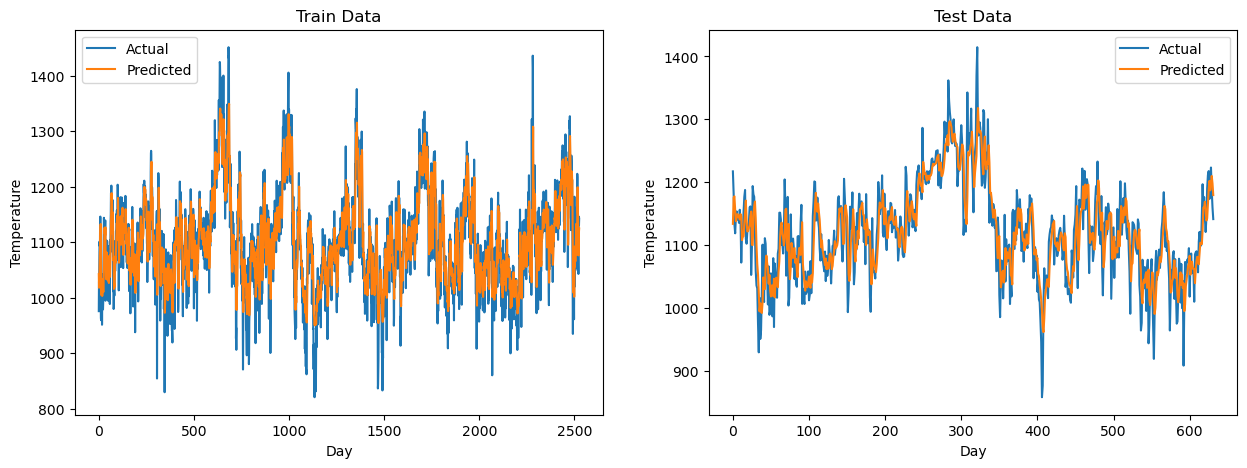

In [551]:
"""
Plot train dan test Actual vs Predicted
"""

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for i, (actual, predicted, title) in enumerate(zip(
    [train_actual, test_actual], 
    [train_predicted, test_predicted], 
    ['Train Data', 'Test Data']
)):
    ax[i].plot(actual, label='Actual')
    ax[i].plot(predicted, label='Predicted')
    ax[i].set_title(title)
    ax[i].set_xlabel('Day')
    ax[i].set_ylabel('Temperature')
    ax[i].legend()

plt.show()